In [1]:
import sys
sys.path.append('../src/lib/')

import torch
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import cv2
import random
#import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import transforms as T
from torchvision.transforms import functional as F
from torch.utils.data import DataLoader, TensorDataset
import torchvision

In [2]:
from models.model import create_model, load_model
import datasets.dataset as dataset
from models.decode import mot_decode, _topk, map2orig

In [3]:
class opts:
    pass

opt = opts()
opt.use_gc = True
opt.gc_cls_names = "Cha,Flo,Gen,Geo,Her,Rab,Red,Uns"
opt.reid_cls_names = "lemur,box"
opt.cat_spec_wh = True
opt.K = 50
opt.down_ratio = 4
opt.ltrb = False
opt.mse_loss = True
opt.gc_with_roi = True
opt.hm_gauss = True
opt.no_aug_hsv = False

output_path = "../exp/id/batch_id_training/"

which_dataset = "base"

dataset_folder_path = os.path.join(output_path, which_dataset)

# Check if the dataset folder exists
if not os.path.exists(dataset_folder_path):
    # If it doesn't exist, create it
    os.makedirs(dataset_folder_path)


dset_train = dataset.JointDataset2(
    opt,
    root="/path/to/your/dataset",
    paths={
		"lemur_train": f'../src/data/lemur_ids_{which_dataset}.train'
	},
    augment=True, transforms = T.Compose([T.ToTensor()])
    )



dataset summary
OrderedDict([('lemur_train', defaultdict(<class 'int'>, {0: 650.0, 1: 696.0}))])
start index
OrderedDict()


In [4]:
dset_val = dataset.ImageLabelDataset(
    root='/path/to/your/dataset',
    file_list='../src/data/lemur_ids.val',
    resize=True
    )

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
val_labels = []
cut_out_objects = []

for i in range(dset_val.__len__()):
    image, img_path, orig_shape, labels = dset_val.__getitem__(i)
    input_image = torch.from_numpy(image).unsqueeze(0)
    bbox = labels[0][2:6,]
    x1, y1, x2, y2 = bbox.tolist()
    width = x2 - x1
    height = y2 - y1
    center_x = (x1 + x2) / 2
    center_y = (y1 + y2) / 2

    # Determine the longer side
    max_side = max(width, height)
    new_width = max_side 
    new_height = max_side 

    # Calculate new coordinates
    new_x1 = center_x - new_width / 2
    new_y1 = center_y - new_height / 2
    new_x2 = center_x + new_width / 2
    new_y2 = center_y + new_height / 2

    new_bbox = [torch.tensor([[new_x1, new_y1, new_x2, new_y2]])]

    roi_output = torchvision.ops.roi_align(input_image, new_bbox, output_size=(224,224))
    cut_out_objects.append(roi_output)
    val_labels.append(labels[0][6,])

        
val_tensor = torch.cat(cut_out_objects, dim=0)
val_labels = torch.tensor(val_labels).long()
val_tensor = val_tensor.to(device)
val_labels = val_labels.to(device)

val_dataset = TensorDataset(val_tensor, val_labels)

batch_size = 64
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)


In [7]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]

        if self.transform:
            sample = self.transform(sample)

        return sample, label

In [9]:
seed = 2
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
np.random.seed(seed)
random.seed(seed)

torch.cuda.empty_cache()

progress_file_path = os.path.join(output_path, which_dataset, "training_progress.txt")

zoom_min = 1.0
zoom_max = 1.2
move_px = 5

num_classes = 8 

model = torchvision.models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.00002) #0.0001

# Initialize variables for early stopping
best_val_loss = float('inf')
patience = 20  # Number of epochs to wait for improvement
counter = 0  # Counter for epochs without improvement

# Step 4: Train the model
num_epochs = 300


with open(progress_file_path, "w") as progress_file:
    for epoch in range(num_epochs):

            
        cut_out_objects = []
        all_labels = []

        for i in range(dset_train.__len__()):
            output = dset_train.__getitem__(i)

            bbox = output['bbox']
            input_image = output['input'].clone().detach().unsqueeze(0)
            box_lemur = output['box_lemur_class'].numpy()
            labels = output['gc'].numpy()
            gt_bbox = bbox[:len(box_lemur)][box_lemur == 0] #ignore foodboxes
            bboxes = []
            new_bboxes = []
            for bbox in gt_bbox:
                x1, y1, x2, y2 = bbox.tolist()
                width = x2 - x1
                height = y2 - y1
                center_x = (x1 + x2) / 2
                center_y = (y1 + y2) / 2
                
                # Determine the longer side
                max_side = max(width, height)
                
                jitter = random.uniform(zoom_min, zoom_max) # this makes the squared bounding boxes slightly larger or smaller 
                #jitter = 1
                new_width = max_side * jitter
                new_height = max_side * jitter

                move = random.uniform(-move_px, move_px)
                #move = 0
                center_x = center_x + move
                center_y = center_y + move
                
                # Calculate new coordinates
                new_x1 = center_x - new_width / 2
                new_y1 = center_y - new_height / 2
                new_x2 = center_x + new_width / 2
                new_y2 = center_y + new_height / 2

                
                new_bbox = [new_x1, new_y1, new_x2, new_y2]
                new_bboxes.append(new_bbox)

            bboxes.append(torch.tensor(new_bboxes))
            all_labels.append(labels)

            roi_output = torchvision.ops.roi_align(input_image, [bbox * 4 for bbox in bboxes], output_size=(224,224))
            cut_out_objects.append(roi_output)
            
        full_tensor = torch.cat(cut_out_objects, dim=0)
        full_labels = torch.tensor(np.concatenate(all_labels))

        # Step 2: Move your model and data to CUDA (GPU) if CUDA is available
        model.to(device)
        if len(full_labels) < 1024:

            full_tensor = full_tensor.to(device)
            full_labels = full_labels.to(device)
            # Create a TensorDataset
            train_dataset = TensorDataset(full_tensor, full_labels)

        else:
            data_batch_size = 128
            # Create a list of batches
            print(full_tensor.shape)
            data_batches = [full_tensor[i:i+data_batch_size] for i in range(0, len(full_tensor), data_batch_size)]
            label_batches = [full_labels[i:i+data_batch_size] for i in range(0, len(full_labels), data_batch_size)]

            # Create and concatenate batches on GPU
            train_datasets = []
            for data_batch, label_batch in zip(data_batches, label_batches):
                data_tensor = data_batch.to(device)
                label_tensor = label_batch.to(device)
                train_datasets.append(CustomDataset(data_tensor, label_tensor))

            # Concatenate datasets
            train_dataset = torch.utils.data.ConcatDataset(train_datasets)

        

        batch_size = 128
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


        model.train()  # Set model to training mode
        running_loss = 0.0
        correct = 0
        total = 0


        # Split the tensor into smaller batches
        num_batches = 1 #(full_tensor.size(0) + batch_size - 1) // batch_size

        # Process each batch separately
        for i in range(num_batches):
            #start_idx = i * batch_size
            #end_idx = min((i + 1) * batch_size, full_tensor.size(0))
            #batch_tensor = full_tensor[start_idx:end_idx].to(device) 
            #batch_labels = full_labels[start_idx:end_idx].to(device)
            #train_dataset = TensorDataset(batch_tensor, batch_labels)
            #train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
            
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                # Compute statistics
                running_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

            model.eval()  # Set model to evaluation mode
            val_running_loss = 0.0
            val_correct = 0
            val_total = 0

            with torch.no_grad():  # No need to compute gradients during validation
                for val_inputs, val_labels in val_loader:
                    val_outputs = model(val_inputs)
                    val_loss = criterion(val_outputs, val_labels)
                    
                    # Compute statistics
                    val_running_loss += val_loss.item() * val_inputs.size(0)
                    _, val_predicted = val_outputs.max(1)
                    val_total += val_labels.size(0)
                    val_correct += val_predicted.eq(val_labels).sum().item()

            
            # Print statistics for the current epoch
            epoch_loss = running_loss / total
            epoch_accuracy = 100. * correct / total

            # Print statistics for the current epoch
            val_epoch_loss = val_running_loss / val_total
            val_epoch_accuracy = 100. * val_correct / val_total

            progress = f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_epoch_accuracy:.2f}%'
            print(progress)
            progress_file.write(progress + '\n')

        # Save model checkpoint
        prefix = 'cnn.'  # Define the prefix you want to add

        # Get the state dictionary of the model
        model_state_dict = model.state_dict()

        # Create a new state dictionary with modified keys
        new_model_state_dict = {}
        for key, value in model_state_dict.items():
            new_key = prefix + key  # Add the prefix to the key
            new_model_state_dict[new_key] = value

        # Save the new state dictionary to the checkpoint
        torch.save(new_model_state_dict, f'{output_path}/{which_dataset}/model_checkpoint_{epoch+1}.pth')

        if val_epoch_loss < best_val_loss:
            best_val_loss = val_epoch_loss
            counter = 0
        else:
            counter += 1

        # Check if early stopping criteria are met
        if counter >= patience:
            print("Early stopping...")
            progress_file.write("Early stopping...")
            break

Epoch [1/300], Loss: 1.9693, Accuracy: 26.17%, Validation Loss: 2.0586, Validation Accuracy: 29.41%
Epoch [2/300], Loss: 1.6957, Accuracy: 44.29%, Validation Loss: 2.0523, Validation Accuracy: 32.35%
Epoch [3/300], Loss: 1.5287, Accuracy: 54.07%, Validation Loss: 2.0324, Validation Accuracy: 35.29%
Epoch [4/300], Loss: 1.3841, Accuracy: 59.55%, Validation Loss: 1.9999, Validation Accuracy: 44.12%
Epoch [5/300], Loss: 1.2808, Accuracy: 64.08%, Validation Loss: 1.9851, Validation Accuracy: 44.12%
Epoch [6/300], Loss: 1.1944, Accuracy: 68.53%, Validation Loss: 1.9592, Validation Accuracy: 47.06%
Epoch [7/300], Loss: 1.0890, Accuracy: 72.49%, Validation Loss: 1.9239, Validation Accuracy: 47.06%
Epoch [8/300], Loss: 1.0117, Accuracy: 75.30%, Validation Loss: 1.8818, Validation Accuracy: 44.12%
Epoch [9/300], Loss: 0.9357, Accuracy: 77.04%, Validation Loss: 1.8185, Validation Accuracy: 47.06%
Epoch [10/300], Loss: 0.8900, Accuracy: 79.62%, Validation Loss: 1.7601, Validation Accuracy: 52.94%

### Visualize validation images

In [9]:
indivs = ['Cha', 'Flo', 'Gen', 'Geo', 'Her', 'Rab', 'Red','Uns']

def display_image_with_boxes_subplot(image, labels, indivs, ax):

    image = image.copy()
    # Extract bounding box coordinates
    x1, y1, x2, y2 = map(int, labels[0][2:6])  # Assuming labels have format (class, x1, y1, x2, y2)

    # Draw bounding box
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # Put label name on top left of bounding box
    label_name = indivs[int(labels[0][6])]
    cv2.putText(image, label_name, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Display image in the subplot
    ax.imshow(image)
    ax.axis('off')

In [ ]:
n = len(dset_val)
fig, axs = plt.subplots(n,1, figsize=(10,n*5))

for i in range(len(dset_val)):
    image, img_path, orig_shape, labels = dset_val.__getitem__(i)
    image = (image.transpose((1, 2, 0)) * 255).astype(np.uint8)
    print(labels)

    #ax = plt.subplot(1, 3, i + 1)
    #axs[i].set_title('{}'.format(indivs[int(labels[0][6,])]))
    axs[i].axis('off')
    display_image_with_boxes_subplot(image, labels, indivs, axs[i])

    if i == (n-1):
        plt.show()
        break

In [10]:
model = torchvision.models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 8)


state_dict = torch.load(os.path.join(output_path, "cleaned1", "model_checkpoint_5.pth"))

# Remove the prefix "cnn." from the keys of the loaded state dictionary
new_state_dict = {}
for key, value in state_dict.items():
    if key.startswith("cnn."):
        new_key = key[len("cnn."):]  # Remove the prefix
        new_state_dict[new_key] = value
    else:
        new_state_dict[key] = value

# Load the modified state dictionary into the model
model.load_state_dict(new_state_dict)

model.to(device);

In [11]:
model.eval()  # Set model to evaluation mode

with torch.no_grad():  # No need to compute gradients during validation
    for val_inputs, val_labels in val_loader:
        output = model(val_inputs)
        
        

In [12]:
indivs = ['Cha', 'Flo', 'Gen', 'Geo', 'Her', 'Rab', 'Red','Uns']
val_inputs = val_inputs.cpu().numpy()
val_labels = val_labels.cpu().numpy()
output = output.detach().cpu().numpy()


In [13]:
val_labels

array([1, 4, 2, 4, 6, 7, 2, 6, 3, 5, 6, 1, 2, 6, 4, 3, 4, 6, 7, 1, 4, 5,
       5, 1, 4, 5, 2, 5, 4, 5, 5, 6, 5, 2])

/tmp/ipykernel_4098389/837120206.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


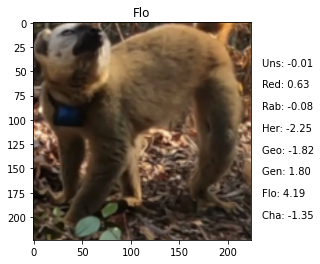

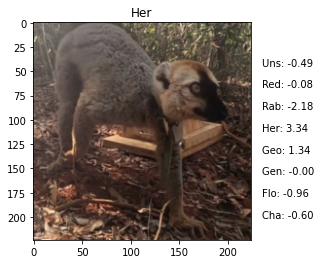

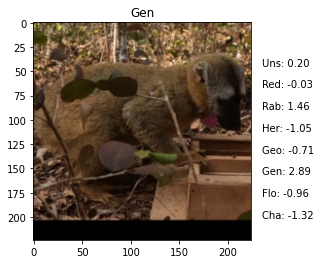

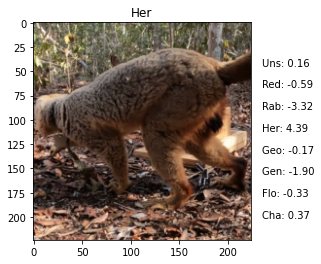

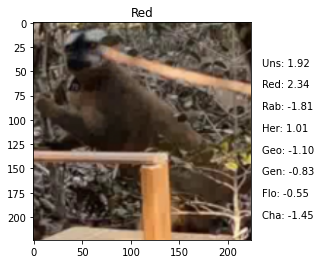

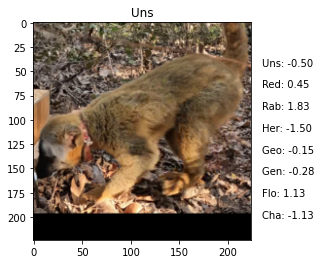

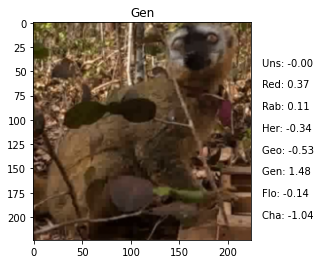

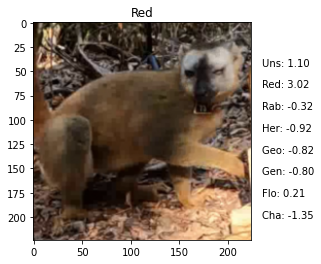

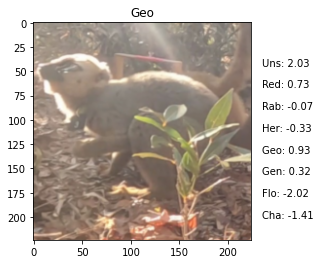

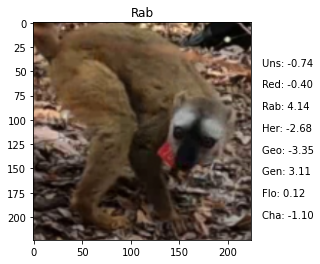

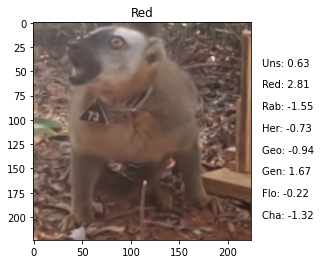

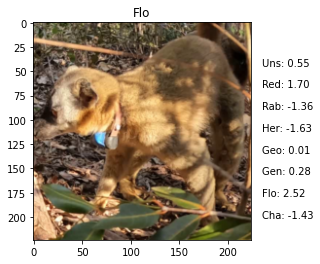

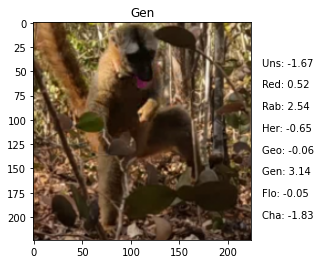

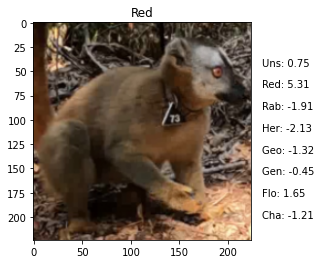

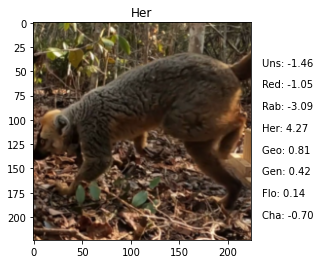

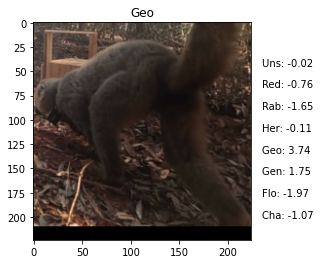

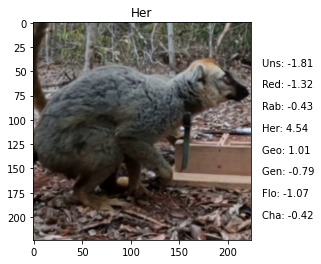

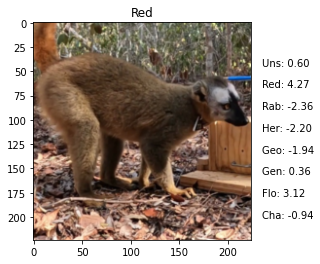

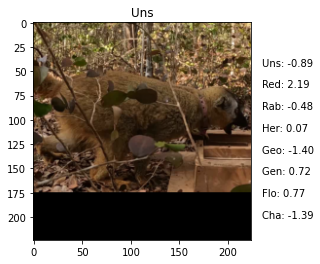

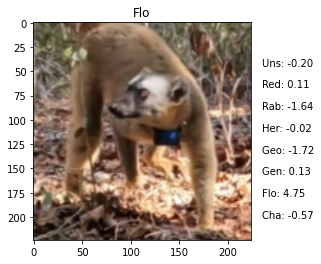

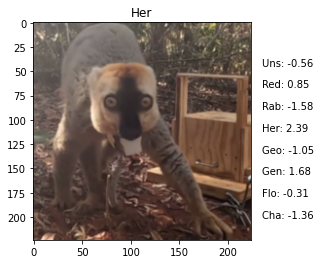

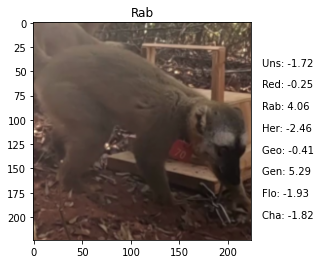

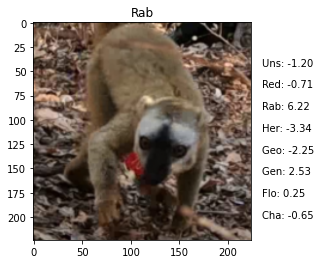

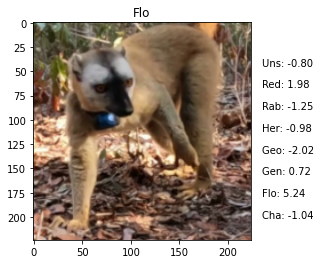

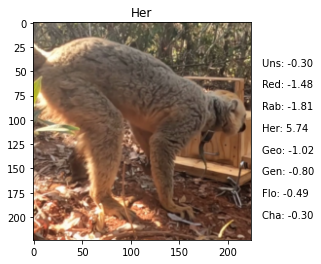

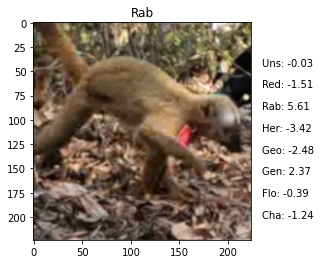

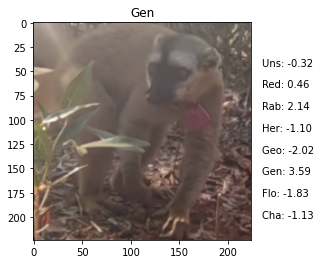

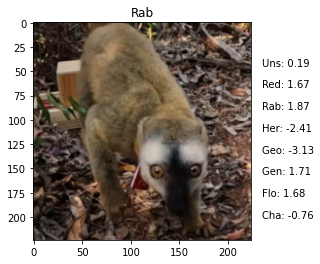

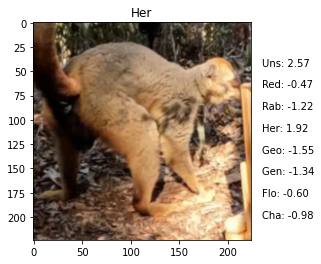

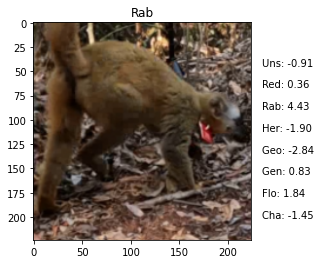

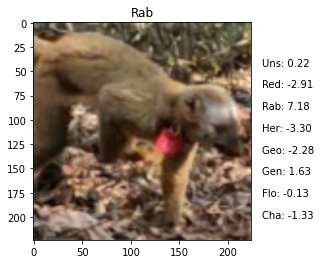

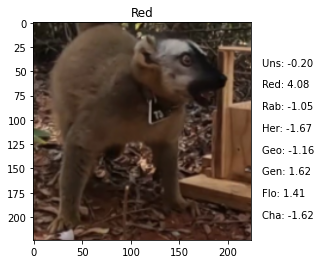

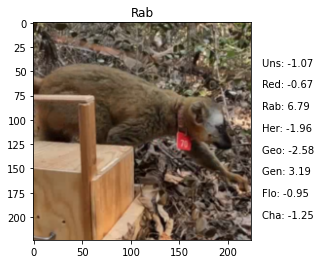

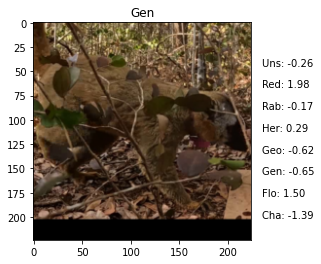

In [14]:

val_images_path = os.path.join(dataset_folder_path, "val_images")
# Check if the dataset folder exists
if not os.path.exists(val_images_path):
    # If it doesn't exist, create it
    os.makedirs(val_images_path)

for i in range(34):

    image = val_inputs[i,:,:,:]
    image = (image.transpose((1, 2, 0)) * 255).astype(np.uint8)
    #plt.imshow(image)
    
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(image)
    ax.set_title(indivs[val_labels[i]])

    # Define the text position
    text_x = 1.05  # Adjust this value to change the distance between image and text
    text_y = 0.1   # Adjust this value to change the vertical position of the text

    # Display text next to the image
    for name, prob in zip(indivs, output[i]):
        ax.text(text_x, text_y, f'{name}: {prob:.2f}', transform=ax.transAxes)
        text_y += 0.1

    fig.savefig(os.path.join(val_images_path, str(i)+".jpg"))


### Visualize training images

It is necessary to run the first part of this script first, with 1 epoch of training.

In [15]:
indivs = ['Cha', 'Flo', 'Gen', 'Geo', 'Her', 'Rab', 'Red','Uns']

Text(0.5, 1.0, 'Uns')

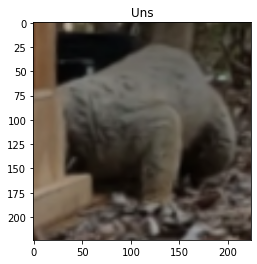

In [16]:
img, label = train_dataset[2]
img = img.detach().cpu().numpy()
img = (img.transpose((1, 2, 0)) * 255).astype(np.uint8)
plt.imshow(img)
plt.title(indivs[label.detach().cpu().numpy()])

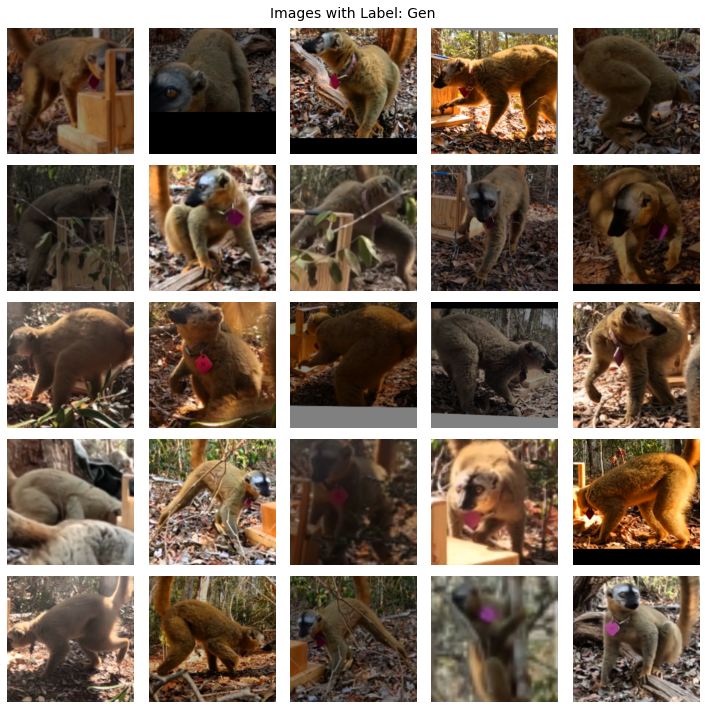

In [18]:

# Define the label for which to display images
target_label = 2

# Define the number of images to display
num_images = 25

# Initialize a figure and axes for subplots
fig, axs = plt.subplots(5, 5, figsize=(10, 10))

# Initialize a list to store indices for the target label
target_label_indices = []

# Iterate through the dataset and store indices for the target label
for idx, (img, label) in enumerate(train_dataset):
    label = label.item()  # Convert label tensor to Python scalar
    if label == target_label:
        target_label_indices.append(idx)

# Randomly select num_images indices
selected_indices = np.random.choice(target_label_indices, num_images, replace=False)

# Iterate through selected indices and display corresponding images
for i, idx in enumerate(selected_indices):
    img, _ = train_dataset[idx]
    img = img.detach().cpu().numpy().transpose((1, 2, 0))
    axs[i // 5, i % 5].imshow(img)
    #axs[i // 5, i % 5].set_title(f"Label: {target_label}")
    axs[i // 5, i % 5].axis('off')

fig.suptitle(f"Images with Label: {indivs[target_label]}", fontsize=14)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()
